<a href="https://colab.research.google.com/github/JuQuiroga/LEX-SEGUROS/blob/main/Entrega_Final_%2BJulieta_Quiroga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Análisis de una Base de Siniestros de Autos: Tendencias Demográficas y Financieras Reveladas**

En un mundo impulsado por la movilidad y la independencia, la conducción de vehículos sigue siendo un aspecto fundamental de la vida cotidiana. Sin embargo, no está exenta de desafíos y riesgos, y uno de los aspectos más críticos es la seguridad en la carretera.

En este análisis, exploraremos la base de datos de siniestros de autos de la compañía de seguros "Lex Seguros" y destacaremos tres aspectos clave sobre la relación entre la demografía de los conductores y la gestión financiera en el contexto de los accidentes automovilísticos.
Para poder crecer como empresa nos brindaron sus datos actuales de base de clientes (rango de edad/género/educación/ingreso/estado civil/hijos) y en base a esto poder comprender el comportamiento respecto a la experiencia de manejo, el uso del auto, si rompen las leyes mediante excesos de velocidad, conducir bajo estupefacientes o mismo la cantidad de siniestros ocurridos que esto lo vemos reflejado en la columna Outcome


*   Preguntas Generales:

  *   ¿Existe una relación entre la edad de los conductores y la cantidad de infracciones por exceso de velocidad?
  *   ¿Se puede identificar alguna asociación entre la edad de los conductores y la propensión a conducir bajo la influencia de estupefacientes?
  *   ¿Cómo se distribuye el historial de accidentes en función de la edad de los conductores?
  *   ¿Existe alguna relación entre la edad de los conductores y sus puntajes de crédito?
  *   ¿Podemos identificar alguna asociación entre la cantidad anual de millas conducidas y los puntajes de crédito?

*   Pregunta Objetivo:
Como compañía de seguros, ¿cómo sabemos qué perfil tiene mayor posibilidad a tener un siniestro?, ¿cuál es el perfil de cartera que queremos en la empresa?

# **Carga de Dataset + Librerias**

In [1]:
pip install xgboost

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib as mpl
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn import datasets, metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [3]:
from google.colab import files

In [4]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/DATA SCIENCE.46275/1ER ENTREGA 6 9/1. ProyectoCar_Insurance_Claim.csv')

## DATOS

In [6]:
df = df.sort_values('AGE')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 3098 to 0
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   ID                              10000 non-null  int64  
 1   AGE                             10000 non-null  object 
 2   GENDER                          10000 non-null  object 
 3   RACE                            10000 non-null  object 
 4   DRIVING_EXPERIENCE              10000 non-null  object 
 5   EDUCATION                       10000 non-null  object 
 6   INCOME                          10000 non-null  object 
 7   CREDIT_SCORE                    9018 non-null   float64
 8   VEHICLE_OWNERSHIP               10000 non-null  float64
 9   VEHICLE_YEAR                    10000 non-null  object 
 10  MARRIED                         10000 non-null  float64
 11  CHILDREN                        10000 non-null  float64
 12  POSTAL_CODE                     1

In [8]:
upper_class_median = df[df['INCOME'] == 'upper class']['CREDIT_SCORE'].median()
middle_class_median = df[df['INCOME'] == 'middle class']['CREDIT_SCORE'].median()
poverty_class_median = df[df['INCOME'] == 'poverty']['CREDIT_SCORE'].median()
working_class_median = df[df['INCOME'] == 'working class']['CREDIT_SCORE'].median()

In [9]:
df.loc[(df[(df['INCOME'] == 'working class') & df['CREDIT_SCORE'].isnull()].index),'CREDIT_SCORE'] = df[df['INCOME'] == 'working class']['CREDIT_SCORE'].fillna(working_class_median)
df.loc[(df[(df['INCOME'] == 'poverty') & df['CREDIT_SCORE'].isnull()].index),'CREDIT_SCORE'] = df[df['INCOME'] == 'poverty']['CREDIT_SCORE'].fillna(poverty_class_median)
df.loc[(df[(df['INCOME'] == 'middle class') & df['CREDIT_SCORE'].isnull()].index),'CREDIT_SCORE'] = df[df['INCOME'] == 'middle class']['CREDIT_SCORE'].fillna(middle_class_median)
df.loc[(df[(df['INCOME'] == 'upper class') & df['CREDIT_SCORE'].isnull()].index),'CREDIT_SCORE'] = df[df['INCOME'] == 'upper class']['CREDIT_SCORE'].fillna(upper_class_median)

In [10]:
df['ANNUAL_MILEAGE'] = df['ANNUAL_MILEAGE'].fillna(df['ANNUAL_MILEAGE'].median())

In [11]:
df.shape

(10000, 19)

In [12]:
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS (driving under influence),PAST_ACCIDENTS,OUTCOME
3098,247693,16-25,female,majority,0-9y,high school,poverty,0.487320,1.0,before 2015,0.0,1.0,10238,16000.0,sedan,0,0,0,1.0
3045,172866,16-25,female,majority,0-9y,none,working class,0.513735,0.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,1.0
3050,833465,16-25,male,majority,0-9y,university,middle class,0.446132,1.0,before 2015,0.0,0.0,10238,14000.0,sedan,0,0,0,1.0
8141,905593,16-25,female,majority,0-9y,university,working class,0.535758,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,1.0
3053,113033,16-25,male,majority,0-9y,high school,working class,0.466328,1.0,before 2015,0.0,0.0,10238,13000.0,sedan,0,0,0,1.0


In [13]:
df.describe().round(2)

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS (driving under influence),PAST_ACCIDENTS,OUTCOME
count,10000.00,10000.00,10000.00,10000.0,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00,10000.00
mean,500521.91,0.52,0.70,0.5,0.69,19864.55,11726.00,1.48,0.24,1.06,0.31
std,290030.77,0.13,0.46,0.5,0.46,18915.61,2681.65,2.24,0.55,1.65,0.46
min,101.00,0.05,0.00,0.0,0.00,10238.00,2000.00,0.00,0.00,0.00,0.00
25%,249638.50,0.42,0.00,0.0,0.00,10238.00,10000.00,0.00,0.00,0.00,0.00
50%,501777.00,0.53,1.00,0.0,1.00,10238.00,12000.00,0.00,0.00,0.00,0.00
75%,753974.50,0.62,1.00,1.0,1.00,32765.00,13000.00,2.00,0.00,2.00,1.00
max,999976.00,0.96,1.00,1.0,1.00,92101.00,22000.00,22.00,6.00,15.00,1.00


In [14]:
null_counts = df.isnull().sum()
data_types = df.dtypes

table_data = pd.concat([null_counts, data_types], axis =1)
table_data.columns = ['Cantidad valores nulos', 'Tipos de Datos']

print(table_data)

                                Cantidad valores nulos Tipos de Datos
ID                                                   0          int64
AGE                                                  0         object
GENDER                                               0         object
RACE                                                 0         object
DRIVING_EXPERIENCE                                   0         object
EDUCATION                                            0         object
INCOME                                               0         object
CREDIT_SCORE                                         0        float64
VEHICLE_OWNERSHIP                                    0        float64
VEHICLE_YEAR                                         0         object
MARRIED                                              0        float64
CHILDREN                                             0        float64
POSTAL_CODE                                          0          int64
ANNUAL_MILEAGE      

In [15]:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
ID,10000.0,500521.91,290030.77,101.00,249638.50,501777.00,753974.50,999976.00
CREDIT_SCORE,10000.0,0.52,0.13,0.05,0.42,0.53,0.62,0.96
VEHICLE_OWNERSHIP,10000.0,0.70,0.46,0.00,0.00,1.00,1.00,1.00
MARRIED,10000.0,0.50,0.50,0.00,0.00,0.00,1.00,1.00
CHILDREN,10000.0,0.69,0.46,0.00,0.00,1.00,1.00,1.00
POSTAL_CODE,10000.0,19864.55,18915.61,10238.00,10238.00,10238.00,32765.00,92101.00
ANNUAL_MILEAGE,10000.0,11726.00,2681.65,2000.00,10000.00,12000.00,13000.00,22000.00
SPEEDING_VIOLATIONS,10000.0,1.48,2.24,0.00,0.00,0.00,2.00,22.00
DUIS (driving under influence),10000.0,0.24,0.55,0.00,0.00,0.00,0.00,6.00
PAST_ACCIDENTS,10000.0,1.06,1.65,0.00,0.00,0.00,2.00,15.00


# **EDA - Análisis Descriptivo**

## Primeros Gráficos

  *   ¿Existe una relación entre la edad de los conductores y la cantidad de infracciones por exceso de velocidad?

En este gráfico vemos que el rango etario que supera la media en términos de exceso de velocidad se encuentra a partir de los 65 años.
Este resultado puede parecer contra intuitivo, ya que a menudo se asocia el exceso de velocidad con conductores jóvenes e imprudentes. Sin embargo, esta tendencia sugiere que entre las personas mayores, en su mayoría de clase alta, existe un grupo que tiende a desafiar los límites de velocidad establecidos. Esto plantea preguntas importantes sobre la educación vial y las medidas de seguridad dirigidas a esta demografía específica.

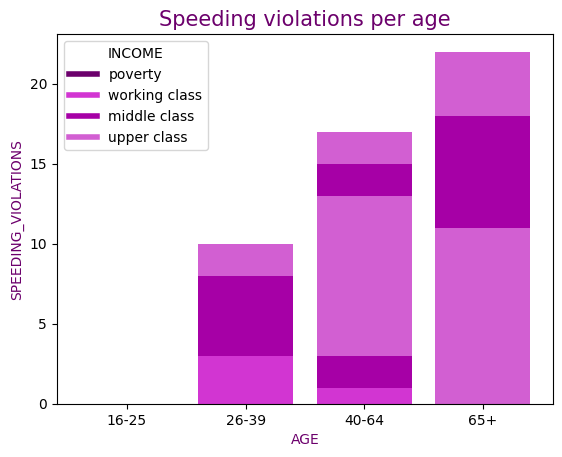

In [16]:
age_ranges = ['16-25', '26-39', '40-64', '65+']
df_filtered = df[df['AGE'].isin(age_ranges)]


x = df['AGE']
y = df['SPEEDING_VIOLATIONS']
income = df['INCOME']

colors = {'poverty': '#6C006C', 'working class': '#D235D2', 'middle class': '#A600A6', 'upper class': '#D25FD2'}
income_colors = [colors[category] for category in income]

fig, ax = plt.subplots()
ax.bar(x, y, color=income_colors)

plt.title('Speeding violations per age',color = "#6C006C", fontsize = 15)
plt.xlabel('AGE', color ='#6C006C')
plt.ylabel('SPEEDING_VIOLATIONS', color ='#6C006C')
legend_labels = [plt.Line2D([0], [0], color=color, lw=4, label=category) for category, color in colors.items()]
plt.legend(handles=legend_labels, title='INCOME', loc='upper left')

plt.show()

  *   ¿Se puede identificar alguna asociación entre la edad de los conductores y la propensión a conducir bajo la influencia de estupefacientes?

El análisis revela que la mayoría de las personas que conducen bajo la influencia de sustancias ilícitas pertenecen al rango etario a partir de los 65 años, nuevamente en su mayoría a la clase media alta.
Este hallazgo sugiere la necesidad de una mayor educación sobre los riesgos y las consecuencias de la conducción bajo los efectos de sustancias ilícitas, especialmente dirigida a este grupo demográfico. Así como también ajustar las tasas de los seguros

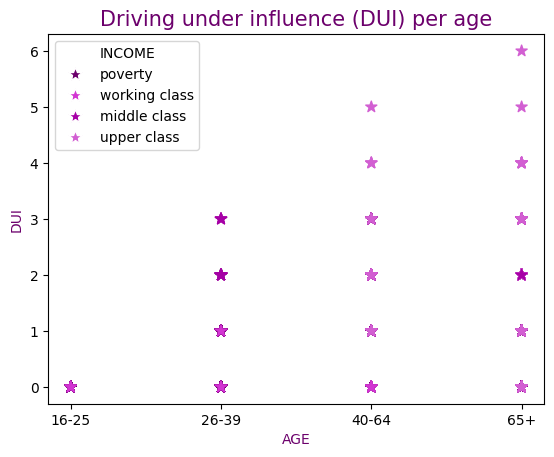

In [17]:
age_ranges = ['16-25', '26-39', '40-64', '65+']
df_filtered = df[df['AGE'].isin(age_ranges)]

x = df['AGE']
y = df['DUIS (driving under influence)']
income = df['INCOME']

colors = {'poverty': '#6C006C', 'working class': '#D235D2', 'middle class': '#A600A6', 'upper class': '#D25FD2'}
income_colors = [colors[category] for category in income]


fig, ax = plt.subplots()
scatter = ax.scatter(x, y, c=income_colors, marker="*", s=70)

plt.title('Driving under influence (DUI) per age', color="#6C006C", fontsize=15)
plt.xlabel('AGE', color='#6C006C')
plt.ylabel('DUI', color='#6C006C')
legend_labels = [plt.Line2D([0], [0], marker='*', color='w', label=category, markersize=10, markerfacecolor=color) for category, color in colors.items()]
plt.legend(handles=legend_labels, title='INCOME', loc='upper left')

plt.show()

  *   ¿Cómo se distribuye el historial de accidentes en función de la edad de los conductores?

Podemos ver en nuestro gráfico que el mayor rango etario propenso a provocar accidentes automovilísticos es a partir de 40 años en adelante.
Resulta importante observar que con el aumento de edad se incrementa la pérdida de capacidad de respuesta física/mental ante un evento inesperado. Podemos entender también que al tener años de conocimiento uno tiene más confianza y no presta atención al volante.

Una buena acción de cara Lex Seguros, sería ajustar  las tasas de los seguros y premiar, bajando las tasas, a aquellos que no hayan tenido infracciones en el año.

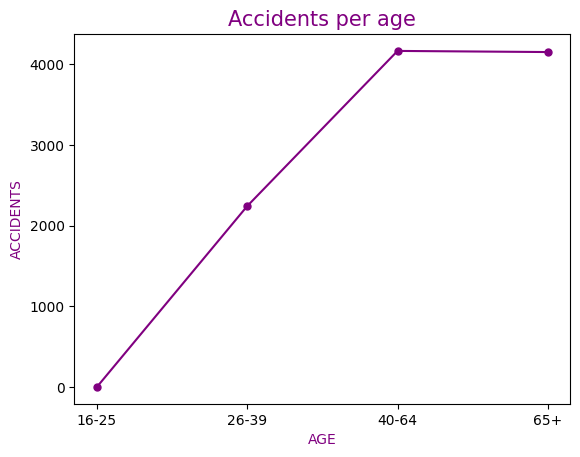

In [18]:
age_ranges = ['16-25', '26-39', '40-64', '65+']
df_filtered = df[df['AGE'].isin(age_ranges)]

age_accidents = df_filtered.groupby('AGE')['PAST_ACCIDENTS'].sum().reset_index()

x = age_accidents['AGE']
y = age_accidents['PAST_ACCIDENTS']

fig, ax = plt.subplots()
ax.plot(x,y, color ='purple', marker = "o", markersize = 5)

plt.title('Accidents per age',color = "purple", fontsize = 15)
plt.xlabel('AGE', color ='purple')
plt.ylabel('ACCIDENTS', color ='purple')

plt.show()

  *   ¿Existe alguna relación entre la edad de los conductores y sus puntajes de crédito?
  
El tercer aspecto resaltado en este análisis es el rango etario más beneficioso para acceder a un crédito, que comienza a partir de los 40 años. Este demuestra la relación entre la edad y la solvencia financiera, a medida que las personas avanzan en su vida laboral y adquieren experiencia financiera, obtienen mejores condiciones para la financiación de vehículos.
Al acceder a créditos es más propenso a que el vehículo se encuentre en mejor estado, ya sea para arreglarlo o cambiarlo


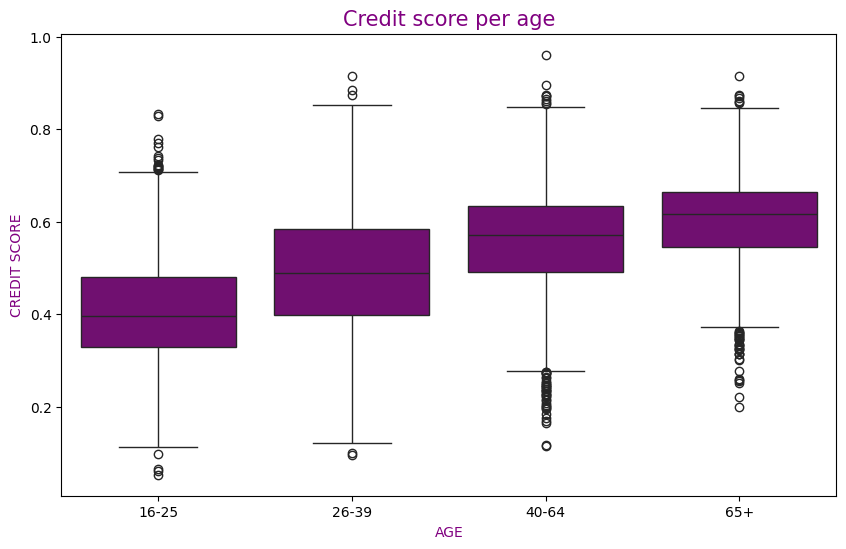

In [19]:
data = {'AGE': ['16-25', '26-39', '40-64', '65+'], 'CREDIT_SCORE': df['CREDIT_SCORE']}

plt.figure(figsize=(10, 6))

sns.boxplot(x='AGE', y='CREDIT_SCORE', data=df, color='purple')

plt.title('Credit score per age', color='purple', fontsize=15)
plt.xlabel('AGE', color='purple')
plt.ylabel('CREDIT SCORE', color='purple')

plt.show()

*   ¿Podemos identificar alguna asociación entre la cantidad anual de millas conducidas y los puntajes de crédito?

Podemos ver que el mayor puntaje crediticio se encuentra antes de los 12000km del auto. Esto nos demuestra que, a mayor score crediticio mayor es el cuidado o cambio del auto y a menor score crediticio mayor son los kilometrajes del auto.

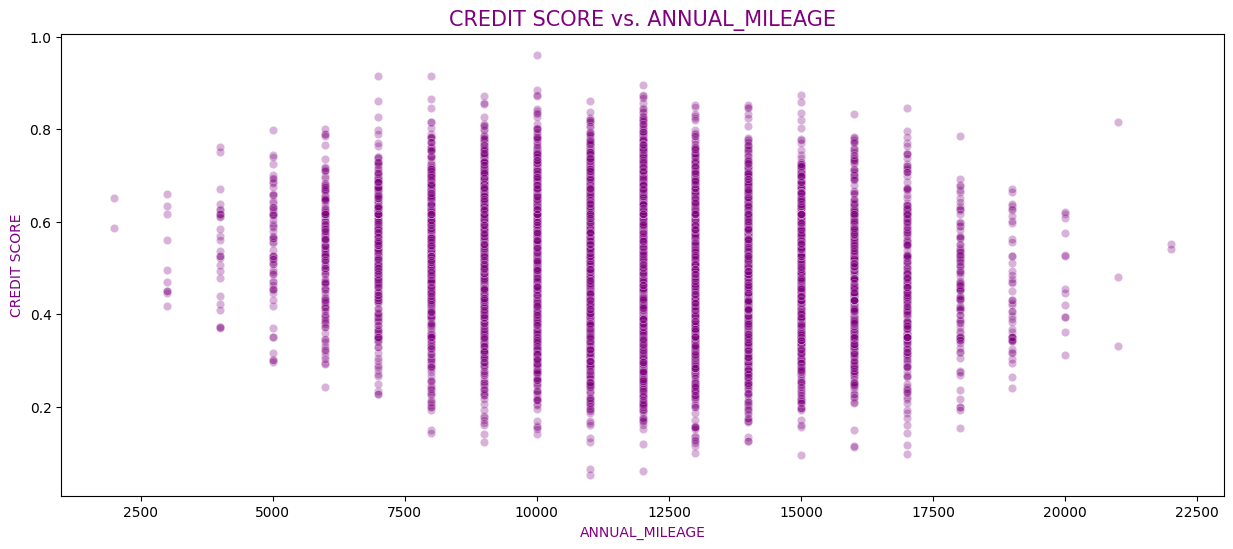

In [20]:
data = {'ANNUAL_MILEAGE': df['ANNUAL_MILEAGE'], 'CREDIT_SCORE': df['CREDIT_SCORE']}

plt.figure(figsize=(15, 6))

sns.scatterplot(x='ANNUAL_MILEAGE', y='CREDIT_SCORE', data=df, color='purple', alpha=0.3)

plt.title('CREDIT SCORE vs. ANNUAL_MILEAGE', color='purple', fontsize=15)
plt.xlabel('ANNUAL_MILEAGE', color='purple')
plt.ylabel('CREDIT SCORE', color='purple')

plt.show()

*   ¿Qué podemos identificar sobre la variable outcome?

Podemos ver que un 68.7% tuvo 0 contacto por siniestro, lo cual nos brinda una tranquilidad sobre el estado de la misma.

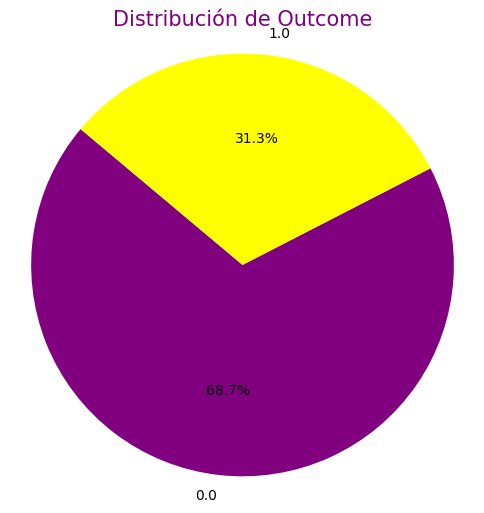

In [21]:
outcome_counts = df['OUTCOME'].value_counts()
custom_colors = ['purple', 'yellow']

plt.figure(figsize=(6, 6))
plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', startangle=140, colors=custom_colors)
plt.title('Distribución de Outcome', color='purple', fontsize=15)

plt.axis('equal')
plt.show()

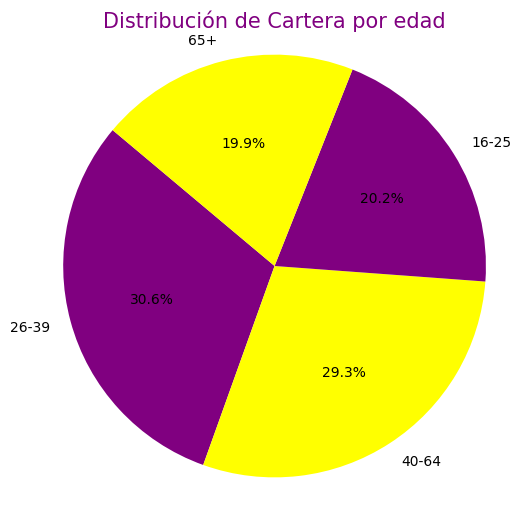

In [22]:
outcome_counts = df['AGE'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', startangle=140, colors=custom_colors)
plt.title('Distribución de Cartera por edad', color='purple', fontsize=15)

plt.axis('equal')
plt.show()

## Matriz de Correlación (Pearson-Spearman-Kendall)

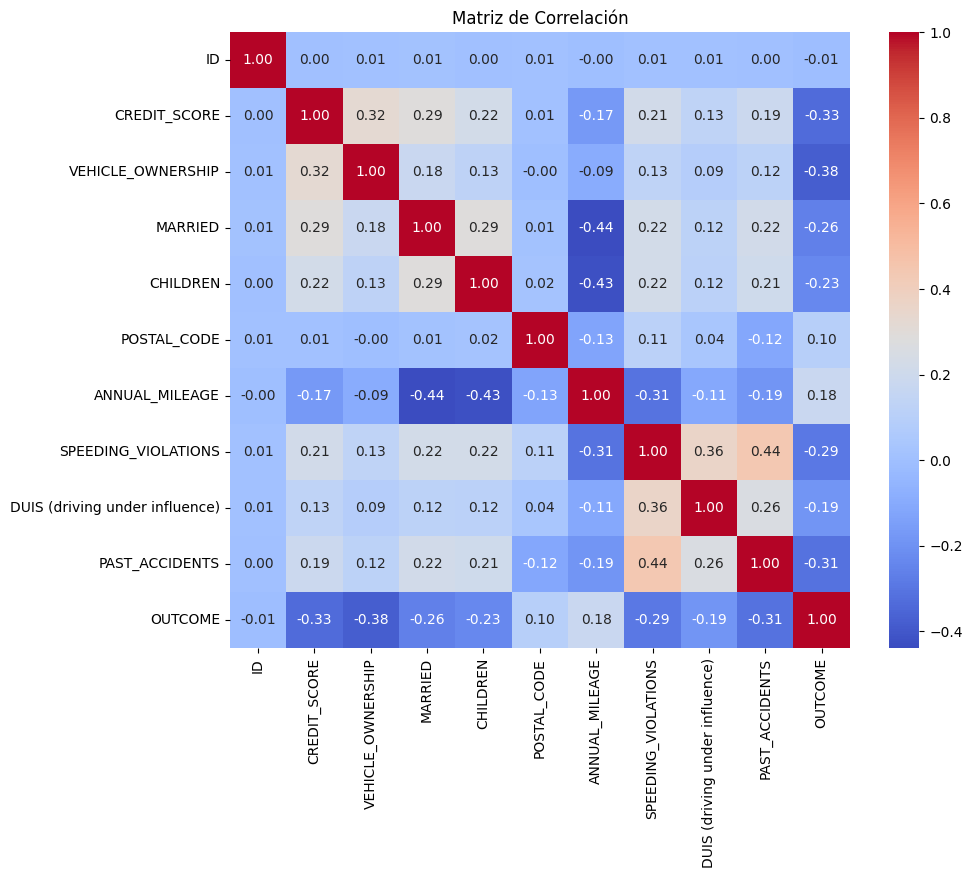

In [23]:
numerical_columns = df.select_dtypes(include='number')
correlation_matrix = numerical_columns.corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')

plt.show()

In [24]:
df.corr(method='pearson')

<ipython-input-24-432dd9d4238b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method='pearson')


,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS (driving under influence),PAST_ACCIDENTS,OUTCOME
ID,1.000000,0.000913,0.009197,0.014826,0.001233,0.006038,-0.002085,0.008156,0.009268,0.001831,-0.010506
CREDIT_SCORE,0.000913,1.000000,0.320825,0.291163,0.223779,0.007742,-0.171290,0.212986,0.131435,0.185135,-0.332641
VEHICLE_OWNERSHIP,0.009197,0.320825,1.000000,0.175626,0.125990,-0.004866,-0.092527,0.133868,0.086567,0.119521,-0.378921
MARRIED,0.014826,0.291163,0.175626,1.000000,0.287009,0.012045,-0.439227,0.218855,0.120840,0.215269,-0.262104
CHILDREN,0.001233,0.223779,0.125990,0.287009,1.000000,0.020911,-0.425509,0.220415,0.115354,0.206295,-0.232835
POSTAL_CODE,0.006038,0.007742,-0.004866,0.012045,0.020911,1.000000,-0.126802,0.113686,0.038492,-0.116985,0.095889
ANNUAL_MILEAGE,-0.002085,-0.171290,-0.092527,-0.439227,-0.425509,-0.126802,1.000000,-0.308303,-0.111454,-0.187678,0.178041
SPEEDING_VIOLATIONS,0.008156,0.212986,0.133868,0.218855,0.220415,0.113686,-0.308303,1.000000,0.359838,0.443074,-0.291862
DUIS (driving under influence),0.009268,0.131435,0.086567,0.120840,0.115354,0.038492,-0.111454,0.359838,1.000000,0.259359,-0.189352
PAST_ACCIDENTS,0.001831,0.185135,0.119521,0.215269,0.206295,-0.116985,-0.187678,0.443074,0.259359,1.000000,-0.311495


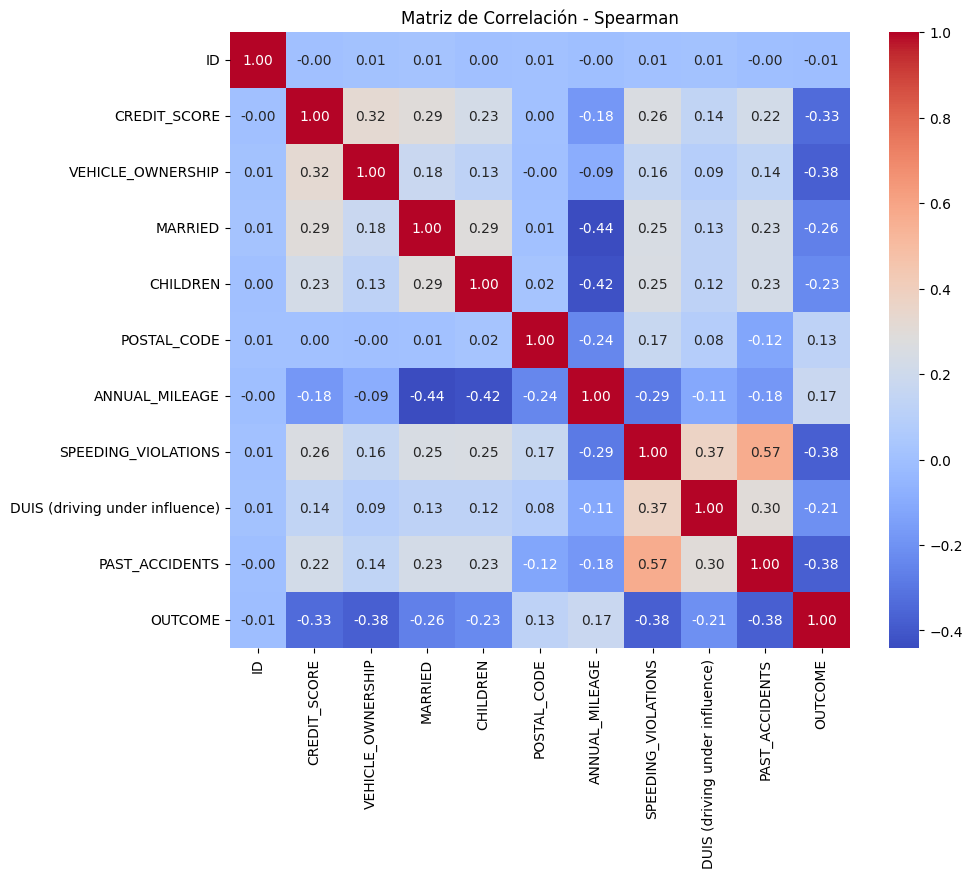

In [25]:
correlation_matrix_spearman = numerical_columns.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_spearman, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación - Spearman')

plt.show()

In [26]:
df.corr(method='spearman')

<ipython-input-26-657b2ea90450>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method='spearman')


,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS (driving under influence),PAST_ACCIDENTS,OUTCOME
ID,1.000000,-0.001092,0.009157,0.014788,0.001253,0.006268,-0.004460,0.006374,0.014702,-0.003608,-0.010426
CREDIT_SCORE,-0.001092,1.000000,0.324192,0.294262,0.226149,0.004538,-0.177376,0.260550,0.140673,0.217918,-0.334993
VEHICLE_OWNERSHIP,0.009157,0.324192,1.000000,0.175626,0.125990,-0.001316,-0.090803,0.157467,0.091172,0.137700,-0.378921
MARRIED,0.014788,0.294262,0.175626,1.000000,0.287009,0.006615,-0.441348,0.246422,0.126688,0.227052,-0.262104
CHILDREN,0.001253,0.226149,0.125990,0.287009,1.000000,0.023666,-0.421500,0.254957,0.122923,0.225998,-0.232835
POSTAL_CODE,0.006268,0.004538,-0.001316,0.006615,0.023666,1.000000,-0.241901,0.167736,0.083437,-0.121002,0.125347
ANNUAL_MILEAGE,-0.004460,-0.177376,-0.090803,-0.441348,-0.421500,-0.241901,1.000000,-0.289088,-0.109385,-0.179032,0.173412
SPEEDING_VIOLATIONS,0.006374,0.260550,0.157467,0.246422,0.254957,0.167736,-0.289088,1.000000,0.370016,0.570122,-0.376809
DUIS (driving under influence),0.014702,0.140673,0.091172,0.126688,0.122923,0.083437,-0.109385,0.370016,1.000000,0.301299,-0.205344
PAST_ACCIDENTS,-0.003608,0.217918,0.137700,0.227052,0.225998,-0.121002,-0.179032,0.570122,0.301299,1.000000,-0.377582


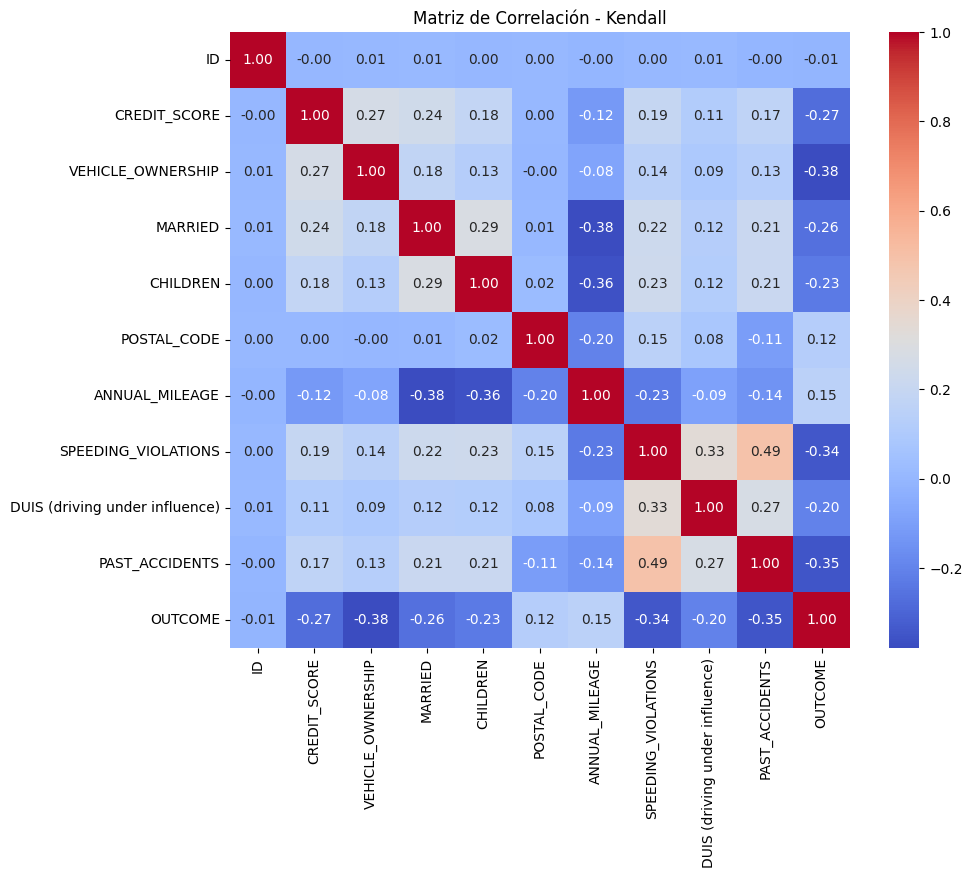

In [27]:
correlation_matrix_kendall = numerical_columns.corr(method='kendall')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_kendall, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación - Kendall')

plt.show()


In [28]:
df.corr(method='kendall')

<ipython-input-28-447f87d54f08>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr(method='kendall')


,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS (driving under influence),PAST_ACCIDENTS,OUTCOME
ID,1.000000,-0.000691,0.007477,0.012075,0.001023,0.004978,-0.003123,0.004730,0.011791,-0.002712,-0.008513
CREDIT_SCORE,-0.000691,1.000000,0.265066,0.240594,0.184904,0.003605,-0.124603,0.194166,0.113054,0.165012,-0.273897
VEHICLE_OWNERSHIP,0.007477,0.265066,1.000000,0.175626,0.125990,-0.001284,-0.078085,0.143233,0.089675,0.127360,-0.378921
MARRIED,0.012075,0.240594,0.175626,1.000000,0.287009,0.006456,-0.379532,0.224147,0.124607,0.210002,-0.262104
CHILDREN,0.001023,0.184904,0.125990,0.287009,1.000000,0.023096,-0.362464,0.231911,0.120904,0.209028,-0.232835
POSTAL_CODE,0.004978,0.003605,-0.001284,0.006456,0.023096,1.000000,-0.202746,0.148594,0.080070,-0.109329,0.122328
ANNUAL_MILEAGE,-0.003123,-0.124603,-0.078085,-0.379532,-0.362464,-0.202746,1.000000,-0.228934,-0.092518,-0.142725,0.149124
SPEEDING_VIOLATIONS,0.004730,0.194166,0.143233,0.224147,0.231911,0.148594,-0.228934,1.000000,0.332981,0.488504,-0.342748
DUIS (driving under influence),0.011791,0.113054,0.089675,0.124607,0.120904,0.080070,-0.092518,0.332981,1.000000,0.274479,-0.201972
PAST_ACCIDENTS,-0.002712,0.165012,0.127360,0.210002,0.209028,-0.109329,-0.142725,0.488504,0.274479,1.000000,-0.349229


## Conclusion

Siendo que nuestro objetivo es poder responder desde la visión de compañía de seguros ¿cómo sabemos qué perfil tiene mayor posibilidad a tener un siniestro? con los gráficos expuestos podemos entender que las personas mayores a 60 años de clase media alta tienen mayor posibilidad a sufrir un siniestro. En contraposición, ese mismo rango y arrancando desde los 40 años vemos que tienen mayor posibilidad a acceder un crédito y por eso pueden mantener el vehículo en mejores condiciones.
Debemos seguir investigando más para entender qué perfil es el ideal para la compañia.


# **Feature Selection + Machine Learning**

## Arbol de Decision + Random Forest

Algoritmo de Clasificación - Arbol de Decisión

In [29]:
x = df.drop("OUTCOME", axis=1)
x.drop(['POSTAL_CODE'], axis = 'columns', inplace=True)
x2 = pd.get_dummies(x, drop_first=True)
y = df.OUTCOME
X_train, X_test, y_train, y_test = train_test_split(x2, y, test_size=0.30, random_state=42)

In [30]:
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
x2.isnull().sum()

ID                                0
CREDIT_SCORE                      0
VEHICLE_OWNERSHIP                 0
MARRIED                           0
CHILDREN                          0
ANNUAL_MILEAGE                    0
SPEEDING_VIOLATIONS               0
DUIS (driving under influence)    0
PAST_ACCIDENTS                    0
AGE_26-39                         0
AGE_40-64                         0
AGE_65+                           0
GENDER_male                       0
RACE_minority                     0
DRIVING_EXPERIENCE_10-19y         0
DRIVING_EXPERIENCE_20-29y         0
DRIVING_EXPERIENCE_30y+           0
EDUCATION_none                    0
EDUCATION_university              0
INCOME_poverty                    0
INCOME_upper class                0
INCOME_working class              0
VEHICLE_YEAR_before 2015          0
VEHICLE_TYPE_sports car           0
dtype: int64

In [31]:
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

Métrica de Validación - Accuracy

In [32]:
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% train:', train_accuracy)
print('% test:',test_accuracy)

% train: 0.7885714285714286
% test: 0.7796666666666666


In [33]:
print(classification_report(y_pred=y_test_pred,y_true=y_test))

              precision    recall  f1-score   support

         0.0       0.78      0.95      0.85      2039
         1.0       0.79      0.43      0.55       961

    accuracy                           0.78      3000
   macro avg       0.78      0.69      0.70      3000
weighted avg       0.78      0.78      0.76      3000



Random Forest

In [34]:
X = df.drop(['OUTCOME'], axis=1)
y = df['OUTCOME']
X = pd.get_dummies(X, drop_first=True)
df.OUTCOME.value_counts()

0.0    6867
1.0    3133
Name: OUTCOME, dtype: int64

In [35]:
(X_train, X_test,y_train, y_test) = train_test_split(X,y,stratify=y,test_size=0.30,random_state=42)
model = RandomForestClassifier(random_state=42, n_estimators=100, class_weight="balanced", max_features="log2")
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
y_test_pred
test_accuracy = accuracy_score(y_test, y_test_pred)

print('% test:',test_accuracy)

% test: 0.8383333333333334


**CONCLUSION**: El 83,6% de las muestras en el conjunto de prueba fueron clasificadas correctamente por el modelo

Matriz de Confusion + Curva ROC

In [36]:
selected_columns = ['CREDIT_SCORE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'PAST_ACCIDENTS']
X = df[selected_columns]
y = df['OUTCOME']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

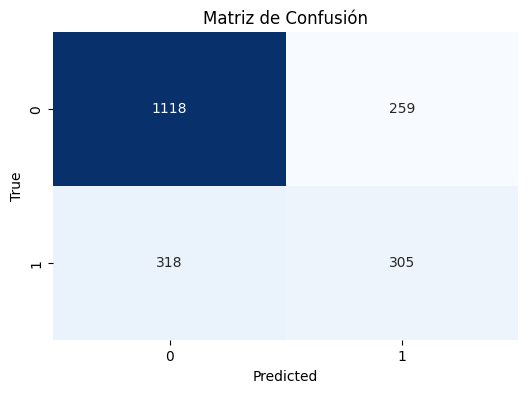

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.78      0.81      0.79      1377
         1.0       0.54      0.49      0.51       623

    accuracy                           0.71      2000
   macro avg       0.66      0.65      0.65      2000
weighted avg       0.70      0.71      0.71      2000



In [37]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusión')
plt.show()

print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

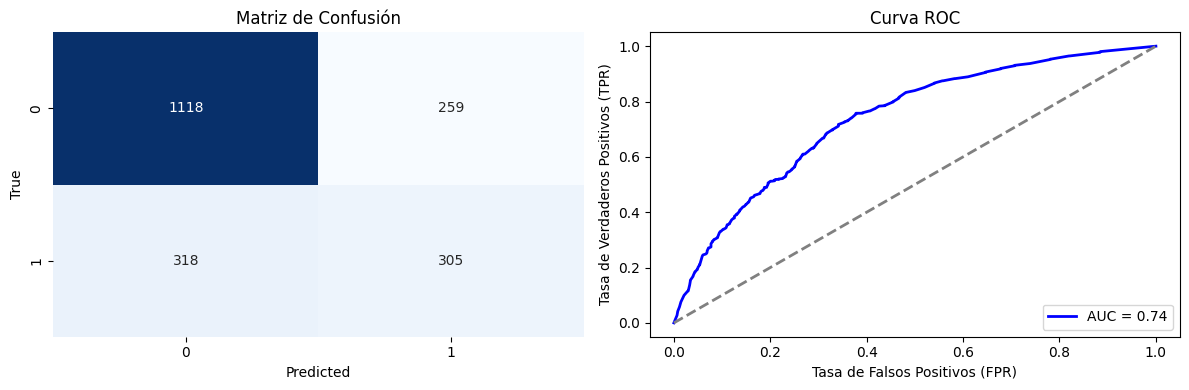

Reporte de Clasificación:
              precision    recall  f1-score   support

         0.0       0.78      0.81      0.79      1377
         1.0       0.54      0.49      0.51       623

    accuracy                           0.71      2000
   macro avg       0.66      0.65      0.65      2000
weighted avg       0.70      0.71      0.71      2000



In [38]:
y_scores = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Matriz de Confusión')


axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].set_title('Curva ROC')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()


print("Reporte de Clasificación:")
print(classification_report(y_test, y_pred))

## CrossValidation para Arbol Decision + Random Forest

In [39]:
kf = KFold(n_splits=5)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train.astype(int))  # Se convierten las etiquetas a enteros
score = clf.score(X_train, y_train)

print("Métrica del modelo:", score)

scores = cross_val_score(clf, X_train, y_train.astype(int), cv=kf, scoring="accuracy")

print("Métricas cross_validation:", scores)
print("Media de cross_validation:", scores.mean())

preds = clf.predict(X_test)
score_pred = metrics.accuracy_score(y_test.astype(int), preds)  # Se convierten las etiquetas a enteros

print("Métrica en Test:", score_pred)

Métrica del modelo: 0.98575
Métricas cross_validation: [0.683125 0.650625 0.689375 0.678125 0.68375 ]
Media de cross_validation: 0.6769999999999999
Métrica en Test: 0.6805


**Conclusion**: No encontramos diferencias entre los modelos elegidos, nos dan un % por arriba del 65%

## XGBoost + KFold + Grindsearch

Algoritmo de Clasificación - XGBOOST

In [40]:
x = df.drop("OUTCOME", axis=1)
x.drop(['POSTAL_CODE'], axis='columns', inplace=True)
x2 = pd.get_dummies(x, drop_first=True)
y = df.OUTCOME

X_train, X_test, y_train, y_test = train_test_split(x2, y,test_size=0.30, random_state=42)

In [41]:
param_grid = {
    'max_depth': [3],
    'learning_rate': [0.01],
    'n_estimators': [100]
}

Métrica de Validación - KFOLD + GridSearchCV

In [42]:
kfold = StratifiedKFold(n_splits=5)

model_base = XGBClassifier()
grid_search = GridSearchCV(estimator=model_base, param_grid=param_grid, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

best_params = grid_result.best_params_

model_final = XGBClassifier(max_depth=best_params['max_depth'], learning_rate=best_params['learning_rate'], n_estimators=best_params['n_estimators'])

model_final.fit(X_train, y_train)

y_train_pred_xgboost = model_final.predict(X_train)
y_test_pred_xgboost= model_final.predict(X_test)

Métrica de Validación - Accuracy

In [43]:
train_accuracy = accuracy_score(y_test, y_test_pred_xgboost)
test_accuracy = accuracy_score (y_test_pred_xgboost, y_test)
accuracy = accuracy_score(y_test, y_test_pred_xgboost)

print('% train:', train_accuracy)
print('% test:',test_accuracy)
print("Exactitud:", accuracy)

% train: 0.784
% test: 0.784
Exactitud: 0.784


Matriz de Confusion + Curva ROC

In [44]:
cm = confusion_matrix(y_test, y_test_pred_xgboost)

print("Matriz de Confusión:")
print(cm)

Matriz de Confusión:
[[1953   86]
 [ 562  399]]


In [45]:
selected_columns = ['CREDIT_SCORE', 'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'PAST_ACCIDENTS']
X = df[selected_columns]
y = df['OUTCOME']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

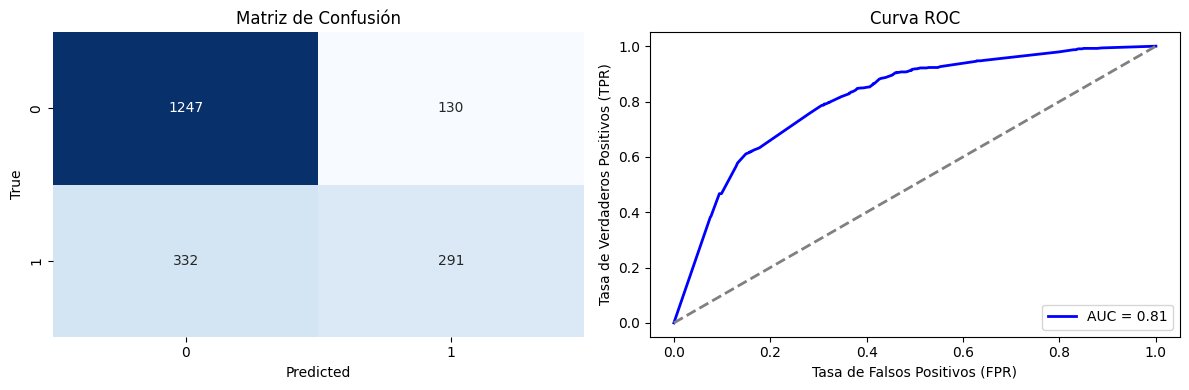

Reporte de Cllasificación:
              precision    recall  f1-score   support

         0.0       0.79      0.91      0.84      1377
         1.0       0.69      0.47      0.56       623

    accuracy                           0.77      2000
   macro avg       0.74      0.69      0.70      2000
weighted avg       0.76      0.77      0.75      2000



In [46]:
model_final.fit(X_train, y_train)
y_pred = model_final.predict(X_test)
y_scores = model_final.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)
conf_matrix = confusion_matrix(y_test,y_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', cbar=False, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Matriz de Confusión')

# Curva ROC
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {roc_auc:.2f}')
axes[1].plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)
axes[1].set_xlabel('Tasa de Falsos Positivos (FPR)')
axes[1].set_ylabel('Tasa de Verdaderos Positivos (TPR)')
axes[1].set_title('Curva ROC')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

print("Reporte de Cllasificación:")
print(classification_report(y_test, y_pred))

## Bias-Variance tradeoff + PCA

Bias-Variance

In [47]:
np.random.seed(123)
X = np.random.uniform(-10, 10, size=(100, 1))
y = 3 * X + np.random.normal(0, 5, size=(100, 1))

k = 5

mse_total = []
bias_squared_total = []
variance_total = []

In [48]:
kf = KFold(n_splits=k)
for train_index, test_index in kf.split(X):
  X_train, X_test = X[train_index], X[test_index]
  y_train, y_test = y[train_index], y[test_index]

  model = LinearRegression()
  model.fit(X_train, y_train)

  predictions_test = model.predict(X_test)

  mse_value = np.mean((predictions_test - y_test) ** 2)

  average_predictions_test=np.mean(predictions_test,axis=0)
  bias_squared_value=np.mean((average_predictions_test -y_test) **2)

  variance_value= np.var(predictions_test,axis=0)

  mse_total.append(mse_value)
  bias_squared_total.append(bias_squared_value)
  variance_total.append(variance_value)

  mse_avg=np.mean(mse_total)
  bias_avg=np.mean(bias_squared_total)
  variance_avg=np.mean(variance_total)

print("MSE Promedio:", mse_avg)
print("Bias^2 Promedio:", bias_avg)
print("Varianza Promedio:", variance_avg)

MSE Promedio: 24.666468071903722
Bias^2 Promedio: 229.90920376273024
Varianza Promedio: 206.66965064879446


PCA

Proporción de Varianza Explicada: [9.90685474e-01 8.93107426e-03 3.83451897e-04]


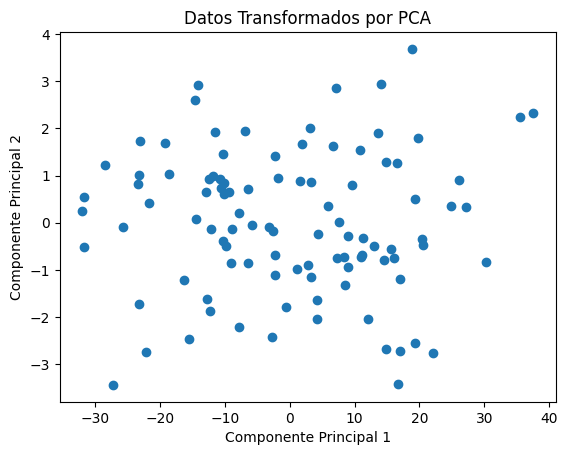

In [49]:
new_variable = np.random.rand(len(X))
data = np.concatenate((X, y.reshape(-1, 1), new_variable.reshape(-1, 1)), axis=1)

pca = PCA(n_components=3)
principal_components = pca.fit_transform(data)

explained_variance_ratio = pca.explained_variance_ratio_
print("Proporción de Varianza Explicada:", explained_variance_ratio)

plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('Datos Transformados por PCA')
plt.show()

# **Conclusión Final**

Tomando en consideración la composición de la cartera, que incluye edad, siniestros, score crediticio, entre otras variables, hemos determinado que la solvencia financiera es mayor en los asegurados de 30 años en adelante.                      
Esto garantiza un mayor movimiento de la cartera para nuestra compañía, "Lex Seguros". Se ha registrado que estos clientes tienden a renovar sus créditos incorporando nuevos beneficios y adquieren nuevos automóviles, lo que aumenta la demanda de nuestros servicios.

Para los nuevos asegurados y cartera actual, todos aquellos mayores a 40 años van a tener un ajuste de tasas, incrementándose en un promedio al valor que se debió indemnizar los casos anteriores, aquellos que no hayan tenido infracciones durante el año, se les bonificará o brindará un descuento en la tasa a modo de premiación.

El 83,6% de las muestras realizadas por el arbol de decision + random forest en el conjunto de prueba fueron clasificadas correctamente por el modelo